### Example 1 - Map of chlorophyll content in the North West Atlantic

The original netCDF Argo files have been converted to parquet format, which provides faster read operations.

There are a couple of way to read parquet files in Python. One is by directly using pandas (make sure you have pyarrow, fastparquet or some other suitable engine installed), the other is with Dask. Generally speaking, you'll want to use Dask if you need a large amount of data at the same time so that you can benefit from its parallelization. You should avoid Dask and just go for pandas whenever the data fits in your RAM.

When reading parquet files with pandas, you can either specificy the file name (if you know which file you want), or the directory containing all the parquet files. In latter case if you apply any filter, pandas and pyarrow will sort through all the files in the folder, reading into memory only the subsets that satisfy your filter.

We start by importing the necessary modules and setting the path and filenames of the parquet files.

In [27]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyarrow.parquet as pq
import glob
from pprint import pprint
parquet_dir = '/vortexfs1/share/boom/data/nc2pqt_test/PQT/'
parquet_files = glob.glob(parquet_dir + '*.parquet')

# We import argopy only for speed comparisons
import argopy
argopy.reset_options()

We now want to set up our filter to read only the data from the NWA (i.e. latitude between 34$^\circ$ and 60$^\circ$, longitude between -45$^\circ$ and -78$^\circ$).

We first query the parquet files for the variable names, as we might not be familiar with them, or we might want to make sure that indeed the names have not been changed from the Argo convention.

In [30]:
dataset = pq.ParquetDataset(parquet_files)
schema = dataset.schema
pprint(sorted(schema.names))

['BBP700',
 'BBP700_ADJUSTED',
 'BBP700_ADJUSTED_ERROR',
 'BBP700_ADJUSTED_QC',
 'BBP700_QC',
 'BBP700_dPRES',
 'CDOM',
 'CDOM_ADJUSTED',
 'CDOM_ADJUSTED_ERROR',
 'CDOM_ADJUSTED_QC',
 'CDOM_QC',
 'CDOM_dPRES',
 'CHLA',
 'CHLA_ADJUSTED',
 'CHLA_ADJUSTED_ERROR',
 'CHLA_ADJUSTED_QC',
 'CHLA_QC',
 'CHLA_dPRES',
 'CYCLE_NUMBER',
 'DOXY',
 'DOXY_ADJUSTED',
 'DOXY_ADJUSTED_ERROR',
 'DOXY_ADJUSTED_QC',
 'DOXY_QC',
 'DOXY_dPRES',
 'JULD',
 'LATITUDE',
 'LONGITUDE',
 'NITRATE',
 'NITRATE_ADJUSTED',
 'NITRATE_ADJUSTED_ERROR',
 'NITRATE_ADJUSTED_QC',
 'NITRATE_QC',
 'NITRATE_dPRES',
 'N_LEVELS',
 'N_PROF',
 'PH_IN_SITU_TOTAL',
 'PH_IN_SITU_TOTAL_ADJUSTED',
 'PH_IN_SITU_TOTAL_ADJUSTED_ERROR',
 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
 'PH_IN_SITU_TOTAL_QC',
 'PH_IN_SITU_TOTAL_dPRES',
 'PLATFORM_NUMBER',
 'PRES',
 'PRES_ADJUSTED',
 'PRES_ADJUSTED_ERROR',
 'PRES_ADJUSTED_QC',
 'PRES_QC',
 'PSAL',
 'PSAL_ADJUSTED',
 'PSAL_ADJUSTED_ERROR',
 'PSAL_ADJUSTED_QC',
 'PSAL_QC',
 'PSAL_dPRES',
 'TEMP',
 'TEMP_ADJUSTED

The geographical coordinates are stored in the variables 'LATITUDE'and 'LONGITUDE'. We then generate the filter, with its syntax being: `[[(column, op, val), …],…]` where `column` is the variable name, and `val` is the value to for the operator `op`, which accepts `[==, =, >, >=, <, <=, !=, in, not in]`,

In [31]:
filter_coords = [("LATITUDE",">",34), ("LATITUDE","<",80),
                 ("LONGITUDE",">",-78), ("LONGITUDE","<",-50)]

With pandas, we pass the filter to the `filters` variable of the `read_parquet()` command:

In [14]:
df = pd.read_parquet( parquet_files , engine='pyarrow', filters = filter_coords )
df

PLATFORM_NUMBER  PRES   LATITUDE  DOXY_ADJUSTED_QC  TEMP_QC  \
N_PROF N_LEVELS                                                                
0      0                 4903798   0.0  56.123187               3.0        8   
       1                 4903798   0.1  56.123187               3.0        8   
       2                 4903798   0.2  56.123187               3.0        8   
       3                 4903798   0.3  56.123187               3.0        8   
       4                 4903798   0.4  56.123187               3.0        8   
...                          ...   ...        ...               ...      ...   
29     1332              4902600   NaN  37.155403               0.0        0   
       1333              4902600   NaN  37.155403               0.0        0   
       1334              4902600   NaN  37.155403               0.0        0   
       1335              4902600   NaN  37.155403               0.0        0   
       1336              4902600   NaN  37.155403               0.0        0   

                 DOXY_ADJUSTED  PSAL_QC        DOXY  TEMP_ADJUSTED_QC  \
N_PROF N_LEVELS                                                         
0      0            327.642975        4  286.802307                 0   
       1            329.894165        4  288.772888                 0   
       2            335.020416        4  293.260162                 0   
       3            349.127930        4  305.609161                 0   
       4            361.651794        4  316.571930                 0   
...                        ...      ...         ...               ...   
29     1332                NaN        0         NaN                 0   
       1333                NaN        0         NaN                 0   
       1334                NaN        0         NaN                 0   
       1335                NaN        0         NaN                 0   
       1336                NaN        0         NaN                 0   

                 TEMP_ADJUSTED  ...  PH_IN_SITU_TOTAL_dPRES  \
N_PROF N_LEVELS                 ...                           
0      0                   NaN  ...                     0.0   
       1                   NaN  ...                     0.0   
       2                   NaN  ...                     0.0   
       3                   NaN  ...                     0.0   
       4                   NaN  ...                     0.0   
...                        ...  ...                     ...   
29     1332                NaN  ...                     NaN   
       1333                NaN  ...                     NaN   
       1334                NaN  ...                     NaN   
       1335                NaN  ...                     NaN   
       1336                NaN  ...                     NaN   

                 PH_IN_SITU_TOTAL_ADJUSTED  PH_IN_SITU_TOTAL_ADJUSTED_QC  \
N_PROF N_LEVELS                                                            
0      0                               NaN                           0.0   
       1                               NaN                           0.0   
       2                               NaN                           0.0   
       3                               NaN                           0.0   
       4                               NaN                           0.0   
...                                    ...                           ...   
29     1332                            NaN                           NaN   
       1333                            NaN                           NaN   
       1334                            NaN                           NaN   
       1335                            NaN                           NaN   
       1336                            NaN                           NaN   

                 PH_IN_SITU_TOTAL_ADJUSTED_ERROR NITRATE  NITRATE_QC  \
N_PROF N_LEVELS                                                        
0      0                                     NaN     NaN         NaN   
 

You can explore the dataframe just by calling it (`df`) as we did above. If you want a list of the variables that are stored, you can use `sorted(df.columns.to_list())`.

#### Timing test

Let's call again the same function, but we time its execution now:

In [15]:
%%time
df = pd.read_parquet( parquet_files , engine='pyarrow', filters = filter_coords )

CPU times: user 1min 13s, sys: 33.1 s, total: 1min 46s
Wall time: 7.56 s


It should have taken a total wall time of 8 to 9 seconds. 

We now want to compare this with Argopy's functionalities. Its data fetcher requires to specificy the depth range, which we then set to between 0 and 10000, i.e. all depths present in the dataset.

NB: the execution should throw an exception (if it doesn't, let me know!). This is likely due to ERDAP's servers timing out after 1 min (as the wall time consistently measures).

In [16]:
%%time
f = argopy.DataFetcher()
f = f.region([-78, -50, 34, 80, 0, 10000])
try:
    f.load()
except Exception as e:
    print(f"Exception: {e}")

Error: 502, message='Proxy Error', url=URL('https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats.nc?data_mode,latitude,longitude,position_qc,time,time_qc,direction,platform_number,cycle_number,config_mission_number,vertical_sampling_scheme,pres,temp,psal,pres_qc,temp_qc,psal_qc,pres_adjusted,temp_adjusted,psal_adjusted,pres_adjusted_qc,temp_adjusted_qc,psal_adjusted_qc,pres_adjusted_error,temp_adjusted_error,psal_adjusted_error&longitude%3E=-78&longitude%3C=-50&latitude%3E=34&latitude%3C=80&pres%3E=0&pres%3C=10000&distinct()&orderBy(%22time,pres%22)')
Exception: https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats.nc?data_mode,latitude,longitude,position_qc,time,time_qc,direction,platform_number,cycle_number,config_mission_number,vertical_sampling_scheme,pres,temp,psal,pres_qc,temp_qc,psal_qc,pres_adjusted,temp_adjusted,psal_adjusted,pres_adjusted_qc,temp_adjusted_qc,psal_adjusted_qc,pres_adjusted_error,temp_adjusted_error,psal_adjusted_error&longitude>=-78&longitude<=-50&latitude>=34&

We just saw that if we need a large amount of data, our parquet-based mirror of Argo's data is faster.

Now let's narrow the filters in the time and depth -- let's say we we want to select the data for the past three months and measured between 0 and 50 db.

In [17]:
from datetime import datetime, timedelta
reference_time = datetime.utcnow() - timedelta(days=90)
filter_coords_time_pres = [("LATITUDE",">",34), ("LATITUDE","<",80),
                           ("LONGITUDE",">",-78), ("LONGITUDE","<",-50),
                           ("JULD",">",reference_time),
                           ("PRES_ADJUSTED",">=",0),("PRES_ADJUSTED","<=",50)]

f = argopy.DataFetcher()
today_date = datetime.today()
old_date = today_date - timedelta(days=90)
today_date = today_date.strftime('%Y-%m')
old_date = old_date.strftime('%Y-%m')
f = f.region([-78, -50, 34, 80, 0, 50, old_date, today_date])

In [18]:
%%time
df = pd.read_parquet( parquet_files , engine='pyarrow', filters = filter_coords_time_pres )

CPU times: user 56.3 s, sys: 15.5 s, total: 1min 11s
Wall time: 5.5 s


In [19]:
%%time
f.load()

/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be change

CPU times: user 1.58 s, sys: 187 ms, total: 1.77 s
Wall time: 2.62 s


<datafetcher.erddap>
Name: Ifremer erddap Argo data fetcher for a space/time region
API: https://erddap.ifremer.fr/erddap
Domain: [x=-78.00/-50.00; y=34.00/80.0 ... 50.0; t=2024-04-01/2024-07-01]
Performances: cache=False, parallel=False
User mode: standard
Dataset: phy

It now took between 5-6 seconds for our Argo mirror, and 2 to 3 seconds using Argo ERDDAP's servers. These can be faster when we need to access a contained amount of data.

#### Map

As we want in this example we are only interested in the chlorophyll, we can specify it as the only column to import (together with the geographical and temporal coordinates):

In [20]:
%%time
ref_var = 'CHLA_ADJUSTED'
cols = [ref_var,"LATITUDE","LONGITUDE","PRES_ADJUSTED","JULD"]
df = pd.read_parquet( parquet_files, engine='pyarrow', filters = filter_coords_time_pres, columns=cols )

CPU times: user 7.06 s, sys: 1.5 s, total: 8.55 s
Wall time: 637 ms


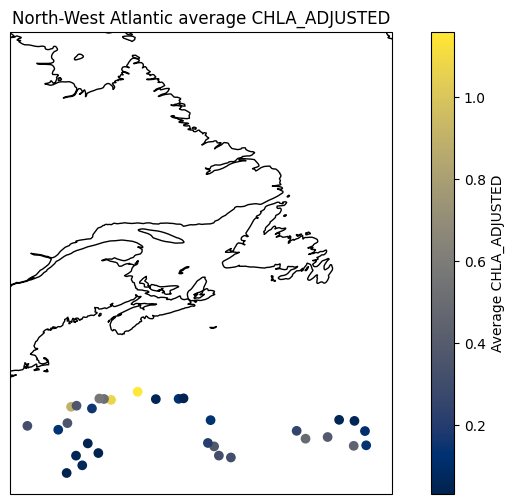

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Convert 'JULD' column to datetime type
df['JULD'] = pd.to_datetime(df['JULD'])

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED', 'JULD', and 'CHLA_ADJUSTED'
grouped = df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    'JULD': lambda x: x.tolist(),  # Collect all time values into a list
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
plt.scatter(grouped['LONGITUDE'], grouped['LATITUDE'], c=grouped[ref_var], cmap='cividis', transform=ccrs.PlateCarree())
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.show()